## EXERCISE 0

Download and extract the Python version of the CIFAR dataset from the CIFAR website.  
The dataset is structured as follows:

- **5 training batches** of 10,000 images each (50,000 images total)  
- **1 test batch** of 10,000 images  

Each batch file contains a **dictionary** with the following elements:

- **`data`** – a 10,000 × 3,072 NumPy array of `uint8`.  
  Each row represents a 32×32 color image:  
  - The first 1,024 entries are the red channel,  
  - The next 1,024 entries are the green channel,  
  - The final 1,024 entries are the blue channel.  
  Images are stored in **row-major order**, i.e., the first 32 entries correspond to the red values of the first row of the image.

- **`labels`** – a list of 10,000 integers in the range 0–9.  
  The number at index `i` indicates the label of the `i`th image in `data`.

The dataset also contains another file called **`batches.meta`**, which is a Python dictionary with the following entry:

- **`label_names`** – a 10-element list giving meaningful names to the numeric labels in the `labels` array described above.  
  For example:  
  ```python
  label_names[0] == "airplane"
  label_names[1] == "automobile"
  # etc.


Number of training samples: 50000
Image shape: torch.Size([3, 32, 32]) Label: 6


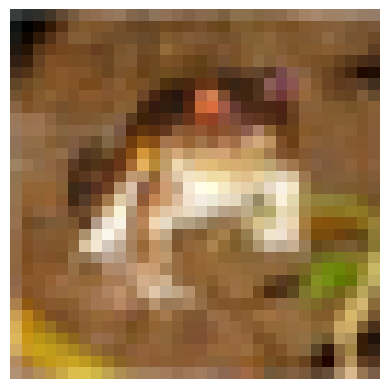

Label: 6


In [1]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        """
        Args:
            path (str): path to the CIFAR-10 data files
            data_type (str): 'train' or 'test'
            transform (callable, optional): transformation to apply to each image
        """
        self.path = path
        self.transform = transform
        self.data = []
        self.labels = []

        if data_type == 'train':
            # load all 5 training batches
            for i in range(1, 6):
                file = f"{path}/data_batch_{i}"
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    # reshape to (10000,3,32,32)
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    self.data.append(imgs)
                    self.labels += batch[b'labels']
            self.data = np.vstack(self.data)  # shape (50000,3,32,32)
        elif data_type == 'test':
            file = f"{path}/test_batch"
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = batch[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # CHW
        label = self.labels[idx]

        # Convert CHW -> HWC for ToTensor
        img = np.transpose(img, (1, 2, 0))

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

    def visualize(self, img):
        """Visualize a single image (tensor or NumPy array)."""
        if isinstance(img, torch.Tensor):
            img = img.clone().detach()
            img = img.numpy()
            img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
            img = img * 0.5 + 0.5  # denormalize
        elif img.max() > 1.0:
            img = img / 255.0  # normalize if uint8

        plt.imshow(img)
        plt.axis('off')
        plt.show()


# ------------------------------
# Main: Instantiate and test
# ------------------------------

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # converts HWC uint8 image to CHW float tensor [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # normalize to [-1,1]
])

# Load the dataset
dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)

# Check dataset size
print("Number of training samples:", len(dataset))

# Get one sample
img, label = dataset[0]
print("Image shape:", img.shape, "Label:", label)

# Visualize first 5 images
for i in range(1):
    img, label = dataset[i]
    dataset.visualize(img)
    print("Label:", label)


## **EXERCISE 2** 
Build a CNN model to predict a class from the input image (you can use
the Conv2D module and one of the plenty pooling layers already implemented).

Which are the main hyperparameters you should set to build the main model?

Good practice is to build the model class as general as possible, and specify the
hyperparaemeters when the class is called.

#### **Explanation**

In the follwing code there is implemented a general convolutional neural network (CNN) that mimics the standard CNN pipeline studied in class:

Convolution → Activation → Pooling → Flatten → Fully connected → Output.


#### **Exercise E2 – Building a General CNN Explanation**

This model defines a <strong>flexible CNN architecture</strong> that can later be configured with
specific hyperparameters (for Exercise E3). It follows exactly the theory from the Convolutional Neural Network lecture.</p>

#### **Main components:**

- <strong>Convolution layers</strong>: learn feature detectors that extract edges, textures, and shapes.
- <strong>Activation (ReLU)</strong>: introduces non-linearity, letting the model learn complex features.
- <strong>Pooling</strong>: reduces spatial size, making the network more robust to position changes.
- <strong>Flattening</strong>: converts 3D feature maps into a 1D vector.
- <strong>Fully Connected layers</strong>: perform the classification using learned features.


#### **Main hyperparameters to specify:**

- Number of convolutional layers and filters
- Kernel size of each convolution
- Pooling type (max or average), kernel, and stride
- Number of neurons in fully connected layers
- Number of output classes

#### **Good practice:**
The model class is <strong>general</strong>: all hyperparameters can be set when the class is called,
and the fully connected layers are created automatically based on the input size. This ensures reusability and avoids hardcoding.</p>




### **Which main hyperparameters must we set?**

1. **Convolutional hyperparameters:**

- conv1_channels, conv2_channels — number of filters in each conv layer (controls model capacity / feature depth). Lecture: depth equals number of filters. 

- kernel_size — the size of each filter (e.g., 5 means 5×5). Larger kernel → bigger receptive field (detects larger patterns). 

- padding and stride — used to control output size and sampling.

2. **Pooling hyperparameters**

- pool_type — 'avg' or 'max' (lecture explains both). Max is common for feature preservation; average sometimes used where smoothing is desirable. 

- pool_kernel & pool_stride — window size and stride for downsampling (lecture: pooling has these hyperparameters). 

3. **Fully connected hyperparameters**

- fc_spatial (Approach A) or fc1_units, fc2_units — number of neurons in FC layers (controls classifier capacity). The lecture mentions designing FC layers after flattening. 

4. **Other general choices**

- num_classes — target number of classes (here CIFAR-10 → 10).

- Activation choice — ReLU is standard and recommended in lecture. 

These are all exposed as __init__ arguments in the model classes above, so I can instantiate many variants without changing the class body.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class GeneralCNN(nn.Module):
    
    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 conv_layers=[(6, 5), (16, 5)], 
                 pool_type='max',
                 pool_kernel=3,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu'): 
        """
        A general CNN model structure for image classification tasks.
        """

        super(GeneralCNN, self).__init__()

        # Salviamo la funzione di attivazione come attributo
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation function")
        
        self.layers = nn.ModuleList()
        current_channels = in_channels

        # Costruzione dei layer convoluzionali
        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size)
            self.layers.append(conv)
            current_channels = out_channels

        # Pooling
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_config = fc_layers
        self.num_classes = num_classes


        # L’inizializzazione dei fully connected layer verrà fatta nel forward
        # dopo aver conosciuto la dimensione flatten


    ## This defines the fully connected layers, because their input size depends on the output size of the convolution+pooling part.
    def build_fc_layers(self, flattened_size): #method that creates the layers dynamically the first time the model runs
        """Define fully connected layers once flattened size is known."""
        layers = []
        input_size = flattened_size
        for units in self.fc_config:
            layers.append(nn.Linear(input_size, units))
            input_size = units
        layers.append(nn.Linear(input_size, self.num_classes))
        self.fc_layers = nn.ModuleList(layers)
        #print(f"Building FC layers with input size {flattened_size}")



    ## Called every time you call the model with data (model(x)):
    # Applies the operations defined in __init__ (and those added in build_fc_layers) to the input data — in the correct sequence.
    def forward(self, x):
        # Apply convolutional layers with optional pooling per layer
        for i, conv in enumerate(self.layers):
            x = conv(x)
            x = self.activation(x)
            if isinstance(self.pool, list):  # multiple pools (optional)
                if i < len(self.pool) and self.pool[i] is not None:
                    x = self.pool[i](x)
            elif self.pool is not None:  # single shared pool (old behavior)
                x = self.pool(x)
        # Flatten
        x = torch.flatten(x, 1)

        # Build FC layers dynamically (first pass)
        if not self.fc_layers:
            self.build_fc_layers(x.shape[1])

        # Fully connected layers
        for i, fc in enumerate(self.fc_layers):
            if i < len(self.fc_layers) - 1:
                x = self.activation(fc(x))
            else:
                x = fc(x)
        return x



REAL DATA MAIN

conda install -c conda-forge ipywidgets; 
conda install tqdm


In [10]:
# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Assuming CIFAR10Dataset and GeneralCNN are already defined above

# 2. Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 3. Dataset
train_dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)
test_dataset = CIFAR10Dataset(path='data', data_type='test', transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Model
model = GeneralCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 5. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 6. Training loop with progress bars + loss tracking
num_epochs = 50
train_losses = [] 

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    running_loss = 0.0
    
    batch_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Batches", leave=False)
    for i, (images, labels) in enumerate(batch_loop):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # Update batch progress bar with current average loss
        batch_loop.set_postfix({"loss": running_loss / (i+1)})
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {epoch_loss:.4f}")

print("Training finished!")


Epoch [1/50] - Avg Loss: 2.3023
Epoch [2/50] - Avg Loss: 2.2999
Epoch [3/50] - Avg Loss: 2.2976
Epoch [4/50] - Avg Loss: 2.2948
Epoch [5/50] - Avg Loss: 2.2918
Epoch [6/50] - Avg Loss: 2.2886
Epoch [7/50] - Avg Loss: 2.2853
Epoch [8/50] - Avg Loss: 2.2820
Epoch [9/50] - Avg Loss: 2.2787
Epoch [10/50] - Avg Loss: 2.2756
Epoch [11/50] - Avg Loss: 2.2726
Epoch [12/50] - Avg Loss: 2.2696
Epoch [13/50] - Avg Loss: 2.2665
Epoch [14/50] - Avg Loss: 2.2632
Epoch [15/50] - Avg Loss: 2.2592
Epoch [16/50] - Avg Loss: 2.2547
Epoch [17/50] - Avg Loss: 2.2496
Epoch [18/50] - Avg Loss: 2.2445
Epoch [19/50] - Avg Loss: 2.2394
Epoch [20/50] - Avg Loss: 2.2347
Epoch [21/50] - Avg Loss: 2.2303
Epoch [22/50] - Avg Loss: 2.2259
Epoch [23/50] - Avg Loss: 2.2216
Epoch [24/50] - Avg Loss: 2.2176
Epoch [25/50] - Avg Loss: 2.2137
Epoch [26/50] - Avg Loss: 2.2099
Epoch [27/50] - Avg Loss: 2.2063
Epoch [28/50] - Avg Loss: 2.2027
Epoch [29/50] - Avg Loss: 2.1993
Epoch [30/50] - Avg Loss: 2.1959
Epoch [31/50] - Avg

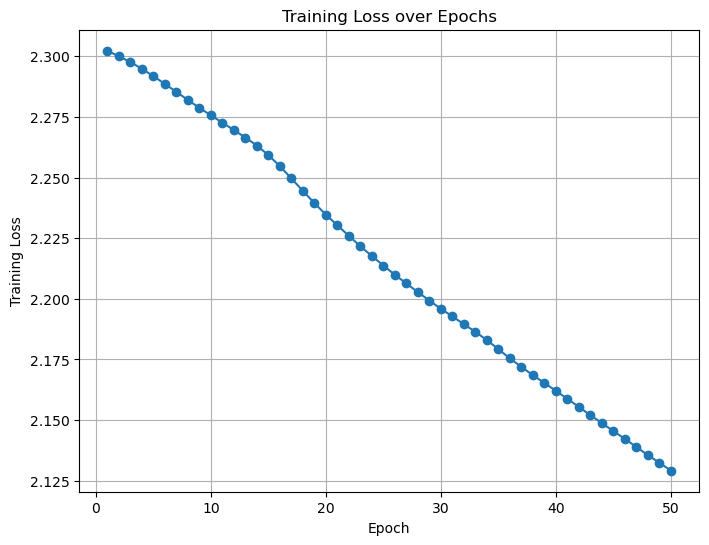

In [11]:
# -----------------------------
# Plot training loss over epochs
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Overall Test Accuracy: 0.2179
              precision    recall  f1-score   support

           0     0.2587    0.7030    0.3783      1000
           1     0.2126    0.0370    0.0630      1000
           2     0.6000    0.0030    0.0060      1000
           3     0.1818    0.2200    0.1991      1000
           4     0.0000    0.0000    0.0000      1000
           5     0.1797    0.6270    0.2793      1000
           6     0.2343    0.3200    0.2705      1000
           7     0.1680    0.0650    0.0937      1000
           8     0.2910    0.0710    0.1141      1000
           9     0.3260    0.1330    0.1889      1000

    accuracy                         0.2179     10000
   macro avg     0.2452    0.2179    0.1593     10000
weighted avg     0.2452    0.2179    0.1593     10000

Mean ROC AUC: 0.7182


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


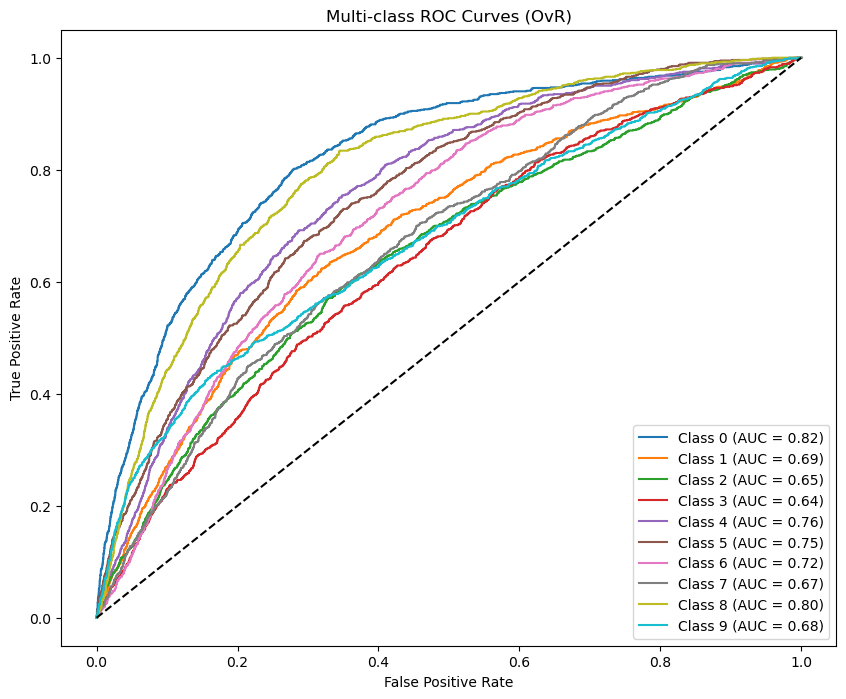

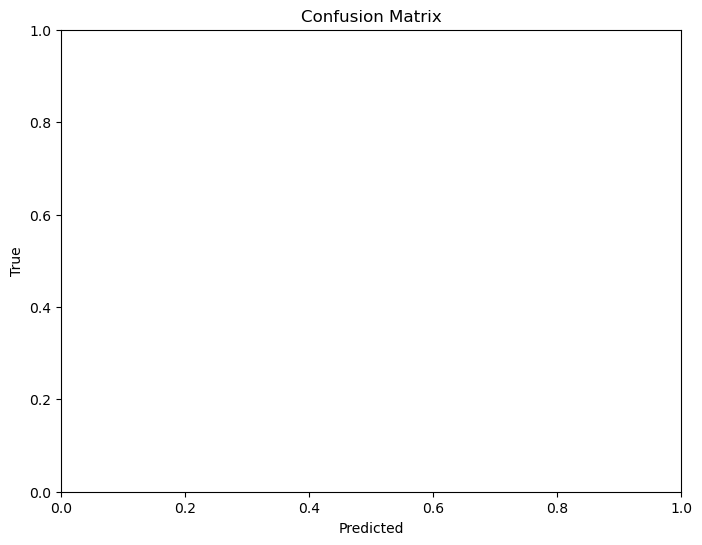

In [12]:
# -----------------------------
# Evaluation
# -----------------------------

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
#import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_preds.append(probs.cpu())
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Accuracy
pred_classes = all_preds.argmax(axis=1)
accuracy = accuracy_score(all_labels, pred_classes)
print(f"Overall Test Accuracy: {accuracy:.4f}")

# Per-class precision, recall, f1
print(classification_report(all_labels, pred_classes, digits=4))

# Mean ROC AUC (one-vs-rest)
n_classes = 10
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
roc_auc = roc_auc_score(all_labels_bin, all_preds, multi_class='ovr')
print(f"Mean ROC AUC: {roc_auc:.4f}")


# Optional: plot ROC curves for each class
plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr,tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.show()

# Optional: Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(8,6))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 62006


Code that adds padding, corrected the kernel size to 3 instead of 2, num_epochs = 50 and batch size 64, still accuracy pretty low :(

Epoch [1/50] - Avg Loss: 2.3031
Epoch [2/50] - Avg Loss: 2.3014
Epoch [3/50] - Avg Loss: 2.2988
Epoch [4/50] - Avg Loss: 2.2947
Epoch [5/50] - Avg Loss: 2.2893
Epoch [6/50] - Avg Loss: 2.2835
Epoch [7/50] - Avg Loss: 2.2773
Epoch [8/50] - Avg Loss: 2.2707
Epoch [9/50] - Avg Loss: 2.2639
Epoch [10/50] - Avg Loss: 2.2574
Epoch [11/50] - Avg Loss: 2.2507
Epoch [12/50] - Avg Loss: 2.2437
Epoch [13/50] - Avg Loss: 2.2368
Epoch [14/50] - Avg Loss: 2.2299
Epoch [15/50] - Avg Loss: 2.2237
Epoch [16/50] - Avg Loss: 2.2176
Epoch [17/50] - Avg Loss: 2.2134
Epoch [18/50] - Avg Loss: 2.2080
Epoch [19/50] - Avg Loss: 2.2038
Epoch [20/50] - Avg Loss: 2.1999
Epoch [21/50] - Avg Loss: 2.1947
Epoch [22/50] - Avg Loss: 2.1905
Epoch [23/50] - Avg Loss: 2.1877
Epoch [24/50] - Avg Loss: 2.1835
Epoch [25/50] - Avg Loss: 2.1797
Epoch [26/50] - Avg Loss: 2.1743
Epoch [27/50] - Avg Loss: 2.1712
Epoch [28/50] - Avg Loss: 2.1686
Epoch [29/50] - Avg Loss: 2.1631
Epoch [30/50] - Avg Loss: 2.1594
Epoch [31/50] - Avg

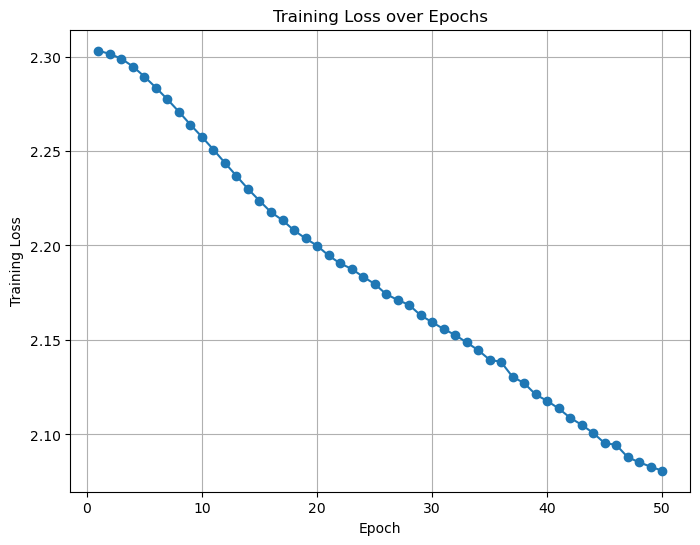

Overall Test Accuracy: 0.2366
              precision    recall  f1-score   support

           0     0.5031    0.0820    0.1410      1000
           1     0.1705    0.8450    0.2837      1000
           2     0.2907    0.1840    0.2254      1000
           3     0.2550    0.0890    0.1319      1000
           4     0.3193    0.1060    0.1592      1000
           5     0.2629    0.3160    0.2870      1000
           6     0.3467    0.3620    0.3542      1000
           7     0.2774    0.3270    0.3001      1000
           8     0.6250    0.0050    0.0099      1000
           9     0.3759    0.0500    0.0883      1000

    accuracy                         0.2366     10000
   macro avg     0.3426    0.2366    0.1981     10000
weighted avg     0.3426    0.2366    0.1981     10000

Mean ROC AUC: 0.7470


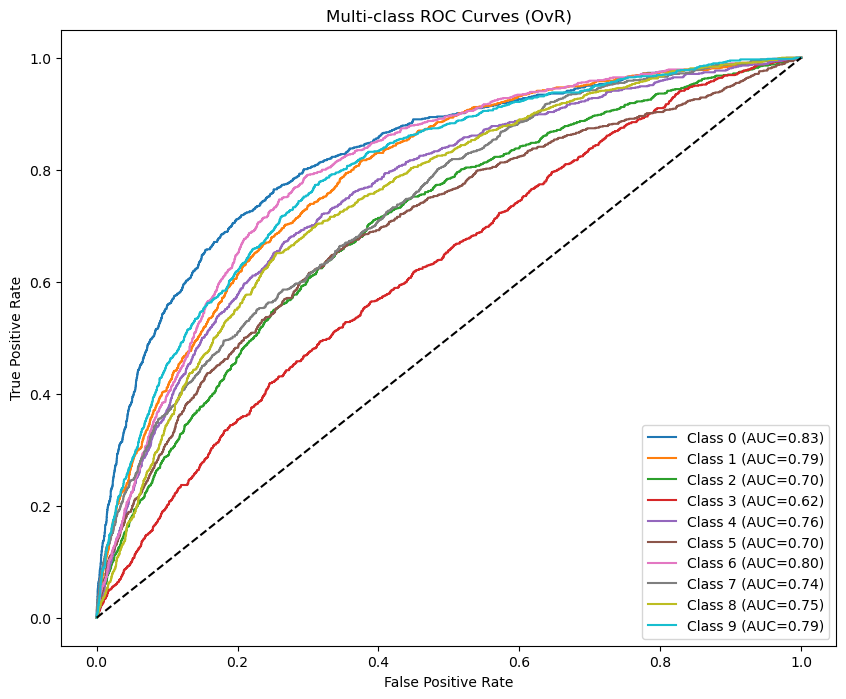

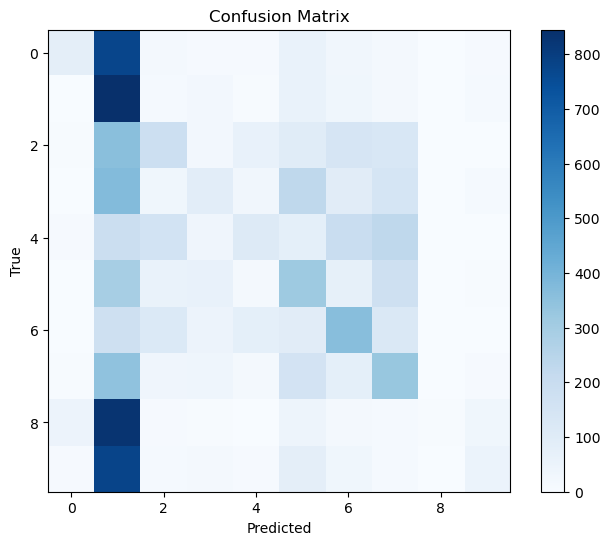

In [17]:
# -----------------------------
# 1. Imports
# -----------------------------
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize

# -----------------------------
# 2. Dataset Class
# -----------------------------
class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        self.path = path
        self.transform = transform
        self.data = []
        self.labels = []

        if data_type == 'train':
            for i in range(1, 6):
                file = f"{path}/data_batch_{i}"
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    self.data.append(imgs)
                    self.labels += batch[b'labels']
            self.data = np.vstack(self.data)
        elif data_type == 'test':
            file = f"{path}/test_batch"
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = batch[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # CHW
        label = self.labels[idx]

        img = np.transpose(img, (1, 2, 0))  # HWC
        img = Image.fromarray(img)  # Convert to PIL Image for torchvision transforms

        if self.transform:
            img = self.transform(img)
        return img, label

    def visualize(self, img):
        if isinstance(img, torch.Tensor):
            img = img.clone().detach()
            img = img.numpy()
            img = np.transpose(img, (1, 2, 0))
            img = img * 0.5 + 0.5  # denormalize
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# -----------------------------
# 3. CNN Model
# -----------------------------
class GeneralCNN(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 conv_layers=[(6, 5), (16, 5)], 
                 pool_type='max',
                 pool_kernel=3,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu'): 
        super(GeneralCNN, self).__init__()

        # Activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation function")

        self.layers = nn.ModuleList()
        current_channels = in_channels

        # Convolutional layers with padding=2 to preserve spatial size
        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size, padding=2)
            self.layers.append(conv)
            current_channels = out_channels

        # Pooling
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        # Fully connected layers (initialized later)
        self.fc_layers = nn.ModuleList()
        self.fc_config = fc_layers
        self.num_classes = num_classes

    def build_fc_layers(self, flattened_size):
        layers = []
        input_size = flattened_size
        for units in self.fc_config:
            layers.append(nn.Linear(input_size, units))
            input_size = units
        layers.append(nn.Linear(input_size, self.num_classes))
        self.fc_layers = nn.ModuleList(layers)

    def forward(self, x):
        for i, conv in enumerate(self.layers):
            x = conv(x)
            x = self.activation(x)
            x = self.pool(x)
        x = torch.flatten(x, 1)

        if not self.fc_layers:
            self.build_fc_layers(x.shape[1])

        for i, fc in enumerate(self.fc_layers):
            if i < len(self.fc_layers) - 1:
                x = self.activation(fc(x))
            else:
                x = fc(x)
        return x

# -----------------------------
# 4. Data and Transformations
# -----------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform_train)
test_dataset = CIFAR10Dataset(path='data', data_type='test', transform=transform_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# 5. Model, Loss, Optimizer
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GeneralCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# -----------------------------
# 6. Training
# -----------------------------
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

# -----------------------------
# 7. Evaluation
# -----------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_preds.append(probs.cpu())
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Accuracy
pred_classes = all_preds.argmax(axis=1)
accuracy = accuracy_score(all_labels, pred_classes)
print(f"Overall Test Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(all_labels, pred_classes, digits=4))

# Mean ROC AUC
n_classes = 10
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
roc_auc = roc_auc_score(all_labels_bin, all_preds, multi_class='ovr')
print(f"Mean ROC AUC: {roc_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc(fpr,tpr):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
